In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
import emm
import warnings
warnings.filterwarnings('ignore')

# Plot styles
plt.style.use('seaborn-notebook')

import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [2]:
# Generate example data
m = 10000

# Target distribution
mu0 = np.array([-0.3]); sig0 = np.array([0.35])
mu1 = np.array([0.2]); sig1 = np.array([0.3])

import scipy as sp
rv0 = sp.stats.skewnorm(a=0, loc=mu0[0], scale=sig0[0])
rv1 = sp.stats.skewnorm(a=0, loc=mu1[0], scale=sig1[0])

X0 = rv0.rvs(size=m // 4)
X1 = rv1.rvs(size=m // 4)
y0 = np.zeros(m // 4)
y1 = np.ones(m // 4)
X = np.concatenate([X0,X1])
y = np.concatenate([y0,y1])


target = pd.DataFrame({'feature' : X})
target['Outcome'] = y

# Corpus distribution
mu = np.array([-1]); sig = np.array([2])
rvc = sp.stats.skewnorm(a=2,loc=mu,scale=sig)
corpus = rvc.rvs(size=m)
corpus = pd.DataFrame({'feature': corpus})

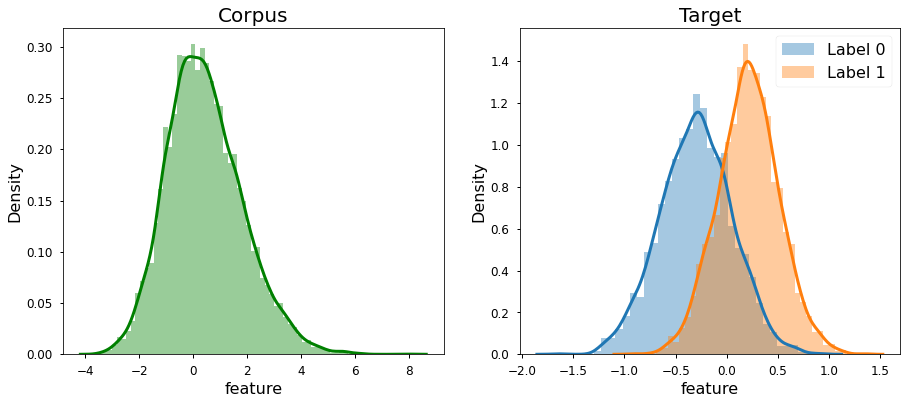

In [3]:
bins_target = np.histogram_bin_edges(target['feature'],bins='auto')
bins = np.histogram_bin_edges(corpus['feature'],bins='auto')


fig, axs = plt.subplots(1,2,figsize=(15,6), sharey=False)

sns.distplot(corpus['feature'], bins=bins,ax=axs[0], kde_kws=dict(linewidth=3), color="green")
sns.distplot(target[target['Outcome']==0]['feature'],ax=axs[1], kde_kws=dict(linewidth=3), label='Label 0')
sns.distplot(target[target['Outcome']==1]['feature'],ax=axs[1], kde_kws=dict(linewidth=3), label='Label 1')
axs[0].set_title('Corpus', fontsize=20)
axs[1].set_title('Target', fontsize=20)
plt.legend(fontsize=16)
plt.savefig('simple_cont_corp_targ_pdf.jpg')

plt.show()

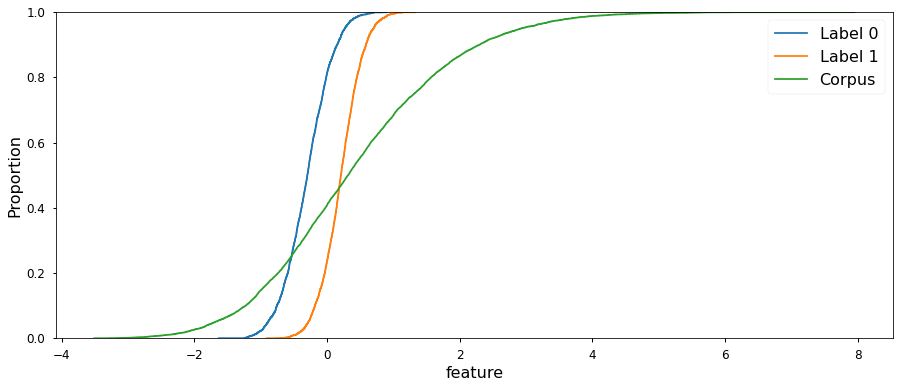

In [4]:
fig, axs = plt.subplots(1,1,figsize=(15,6), sharey=False)


sns.ecdfplot(target[target['Outcome']==0]['feature'],ax=axs,label='Label 0')
sns.ecdfplot(target[target['Outcome']==1]['feature'],ax=axs, label='Label 1')
sns.ecdfplot(corpus['feature'],ax=axs, label='Corpus')
plt.legend(fontsize=16)
plt.savefig('simple_cont_corp_targ_cdf.jpg')

plt.show()

In [5]:
from emm.reweighting import marginal
histLoss0 = emm.losses.CorpusKLLoss(mean=mu0[0], std=sig0[0],scale=1)
histLoss1 = emm.losses.CorpusKLLoss(mean=mu1[0], std=sig1[0], scale=1)



lam = 0
margsKL = {
            0 : [marginal('feature', histLoss0.fun, histLoss0)],
            1 : [marginal('feature', histLoss1.fun, histLoss1)]
          }
                              
margsLS = {
            0 : [marginal('feature', 'mean', emm.losses.LeastSquaresLoss(mu0[0], scale=1), True),
                 marginal('feature', 'var', emm.losses.LeastSquaresLoss(sig0[0]**2, scale=1), True)],
                                  
            1 : [marginal('feature', 'mean', emm.losses.LeastSquaresLoss(mu1[0], scale=1), True),
                marginal('feature', 'var', emm.losses.LeastSquaresLoss(sig1[0]**2, scale=1), True)]
           }

margsEQ = {
            0 : [marginal('feature', 'mean', emm.losses.EqualityLoss(mu0[0]), True)],
                 #marginal('feature', 'var', emm.losses.LeastSquaresLoss(sig0[0]**2), True)],
                                  
            1 : [marginal('feature', 'mean', emm.losses.EqualityLoss(mu1[0]), True)],
                #marginal('feature', 'var', emm.losses.LeastSquaresLoss(sig1[0]**2), True)]
           }

    

    
margs = [margsKL, margsLS]

from sklearn.linear_model import LogisticRegression
param_grid_log =  {"classifier" : [LogisticRegression()],
                 "classifier__C": np.logspace(-3,2,10), 
                   "classifier__penalty":["l1","l2"]}

from sklearn.tree import DecisionTreeClassifier
param_grid_tree =  {'classifier' : [DecisionTreeClassifier()],
     'classifier__max_depth' : [2,4,5,6,7,9]}


from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'classifier' : [RandomForestClassifier()],
    'classifier__bootstrap': [True],
    'classifier__max_depth': [2,3,5,8],
    'classifier__min_samples_leaf': [0,1,2,4],
    'classifier__min_samples_split': [0,1,2,4],
    'classifier__n_estimators': [1,2,3]
}

param_grid = [param_grid_log, param_grid_tree, param_grid_rf]


   
(rwcs1, js1, score1) =emm.metrics.multiple_models(target,corpus,margs, 
                                        param_grid, verbose=True, 
                                    regularizer=emm.regularizers.EntropyRegularizer(), lam=0, test_size=0.2)
(rwcs2, js2, score2) =emm.metrics.multiple_models(target,corpus,margs, 
                                        param_grid, verbose=True, 
                                    regularizer=emm.regularizers.EntropyRegularizer(), lam=0.01, test_size=0.2)
(rwcs3, js3, score3) =emm.metrics.multiple_models(target,corpus,margs, 
                                        param_grid, verbose=True, 
                                    regularizer=emm.regularizers.EntropyRegularizer(), lam=10, test_size=0.2)

CVX took 0.91202 seconds
CVX took 1.96296 seconds
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Target data: the best parameters are given by 
 LogisticRegression(C=2.1544346900318843)
 the best mean cross-validation accuracy 78.8 +/- 0.83516% on training dataset 

Weighted data: the best parameters are given by 
 LogisticRegression(C=2.1544346900318843)
 the best mean cross-validation accuracy 78.29046 +/- 1.63172% on training dataset 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Target data: the best parameters are given by 
 DecisionTreeClassifier(max_depth=2)
 the best mean cross-validation accuracy 78.825 +/- 1.51781% on training dataset 

Weighted data: the best parameters are given by 
 DecisionTreeClassifier(max_depth=2)
 the best mean cross-validation accuracy 79.09948 +/- 1.06943% on training dataset 

Fitting 5 folds for ea


Weighted data: the best parameters are given by 
 DecisionTreeClassifier(max_depth=2)
 the best mean cross-validation accuracy 50.69779 +/- 0.70605% on training dataset 

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Target data: the best parameters are given by 
 RandomForestClassifier(max_depth=3, min_samples_leaf=4, min_samples_split=4,
                       n_estimators=1)
 the best mean cross-validation accuracy 78.9 +/- 1.35877% on training dataset 

Weighted data: the best parameters are given by 
 RandomForestClassifier(max_depth=3, min_samples_leaf=4, min_samples_split=4,
                       n_estimators=1)
 the best mean cross-validation accuracy 51.47063 +/- 0.78792% on training dataset 



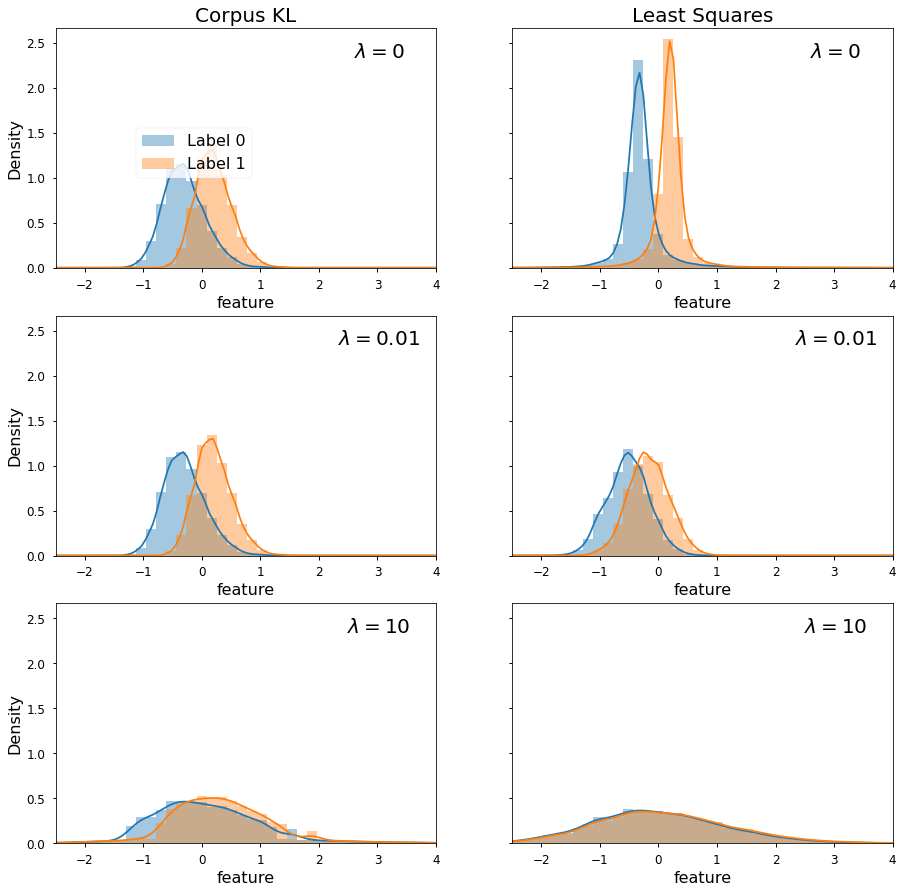

In [6]:
fig, axs = plt.subplots(3,2, figsize=(15,15), sharey=True)
emm.utils.weighted_hist(rwcs1[0]['feature'][:m], rwcs1[0]['weights'][:m], ax=axs[0,0],label='Label 0')
emm.utils.weighted_hist(rwcs1[0]['feature'][m:], rwcs1[0]['weights'][m:], ax=axs[0,0],label='Label 1')
emm.utils.weighted_hist(rwcs1[1]['feature'][:m], rwcs1[1]['weights'][:m], ax=axs[0,1])
emm.utils.weighted_hist(rwcs1[1]['feature'][m:], rwcs1[1]['weights'][m:], ax=axs[0,1])
emm.utils.weighted_hist(rwcs2[0]['feature'][:m], rwcs2[0]['weights'][:m], ax=axs[1,0])
emm.utils.weighted_hist(rwcs2[0]['feature'][m:], rwcs2[0]['weights'][m:], ax=axs[1,0])
emm.utils.weighted_hist(rwcs2[1]['feature'][:m], rwcs2[1]['weights'][:m], ax=axs[1,1])
emm.utils.weighted_hist(rwcs2[1]['feature'][m:], rwcs2[1]['weights'][m:], ax=axs[1,1])
emm.utils.weighted_hist(rwcs3[0]['feature'][:m], rwcs3[0]['weights'][:m], ax=axs[2,0])
emm.utils.weighted_hist(rwcs3[0]['feature'][m:], rwcs3[0]['weights'][m:], ax=axs[2,0])
emm.utils.weighted_hist(rwcs3[1]['feature'][:m], rwcs3[1]['weights'][:m], ax=axs[2,1])
emm.utils.weighted_hist(rwcs3[1]['feature'][m:], rwcs3[1]['weights'][m:], ax=axs[2,1])
axs[0,0].set_title('Corpus KL',fontsize=20)
axs[0,1].set_title('Least Squares', fontsize=20)
axs[2,0].text(0.85, 0.9, '$\lambda = 10$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[2,0].transAxes)
axs[2,1].text(0.85, 0.9, '$\lambda = 10$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[2,1].transAxes)
axs[1,0].text(0.85, 0.9, '$\lambda = 0.01$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[1,0].transAxes)
axs[1,1].text(0.85, 0.9, '$\lambda = 0.01$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[1,1].transAxes)
axs[0,0].text(0.85, 0.9, '$\lambda = 0$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[0,0].transAxes)
axs[0,1].text(0.85, 0.9, '$\lambda = 0$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[0,1].transAxes)
fig.legend(loc = (0.15,0.8), fontsize=16)
plt.setp(axs, xlim=(-2.5,4))
plt.savefig('simple_cont_compare_pdf.jpg')
plt.show()

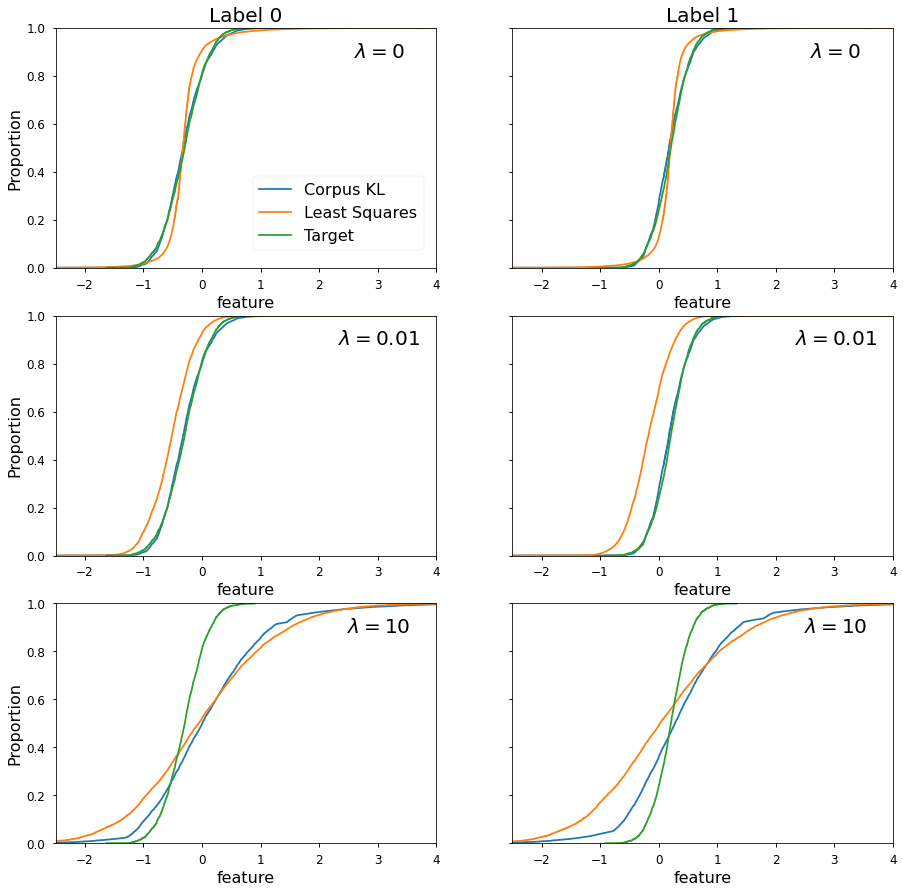

In [7]:
fig, axs = plt.subplots(3,2, figsize=(15,15), sharey=True)
sns.ecdfplot(x=rwcs1[0]['feature'][:m], weights=rwcs1[0]['weights'][:m], ax=axs[0,0], label='Corpus KL')
sns.ecdfplot(x=rwcs1[1]['feature'][:m], weights=rwcs1[1]['weights'][:m], ax=axs[0,0], label='Least Squares')
sns.ecdfplot(target[target['Outcome'] == 0]['feature'], ax=axs[0,0], label='Target')
sns.ecdfplot(x=rwcs1[0]['feature'][m:], weights=rwcs1[0]['weights'][m:], ax=axs[0,1])
sns.ecdfplot(x=rwcs1[1]['feature'][m:], weights=rwcs1[1]['weights'][m:], ax=axs[0,1])
sns.ecdfplot(target[target['Outcome'] == 1]['feature'], ax=axs[0,1])
sns.ecdfplot(x=rwcs2[0]['feature'][:m], weights=rwcs2[0]['weights'][:m], ax=axs[1,0])
sns.ecdfplot(x=rwcs2[1]['feature'][:m], weights=rwcs2[1]['weights'][:m], ax=axs[1,0])
sns.ecdfplot(target[target['Outcome'] == 0]['feature'], ax=axs[1,0])
sns.ecdfplot(x=rwcs2[0]['feature'][m:], weights=rwcs2[0]['weights'][m:], ax=axs[1,1])
sns.ecdfplot(x=rwcs2[1]['feature'][m:], weights=rwcs2[1]['weights'][m:], ax=axs[1,1])
sns.ecdfplot(target[target['Outcome'] == 1]['feature'], ax=axs[1,1])
sns.ecdfplot(x=rwcs3[0]['feature'][:m], weights=rwcs3[0]['weights'][:m], ax=axs[2,0])
sns.ecdfplot(x=rwcs3[1]['feature'][:m], weights=rwcs3[1]['weights'][:m], ax=axs[2,0])
sns.ecdfplot(target[target['Outcome'] == 0]['feature'], ax=axs[2,0])
sns.ecdfplot(x=rwcs3[0]['feature'][m:], weights=rwcs3[0]['weights'][m:], ax=axs[2,1])
sns.ecdfplot(x=rwcs3[1]['feature'][m:], weights=rwcs3[1]['weights'][m:], ax=axs[2,1])
sns.ecdfplot(target[target['Outcome'] == 1]['feature'], ax=axs[2,1])
axs[0,0].set_title('Label 0',fontsize=20)
axs[0,1].set_title('Label 1', fontsize=20)
axs[2,0].text(0.85, 0.9, '$\lambda = 10$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[2,0].transAxes)
axs[2,1].text(0.85, 0.9, '$\lambda = 10$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[2,1].transAxes)
axs[1,0].text(0.85, 0.9, '$\lambda = 0.01$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[1,0].transAxes)
axs[1,1].text(0.85, 0.9, '$\lambda = 0.01$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[1,1].transAxes)
axs[0,0].text(0.85, 0.9, '$\lambda = 0$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[0,0].transAxes)
axs[0,1].text(0.85, 0.9, '$\lambda = 0$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[0,1].transAxes)
fig.legend(loc = (0.28,0.72), fontsize=16)
plt.setp(axs, xlim=(-2.5,4))
plt.savefig('simple_cont_compare_cdf.jpg')
plt.show()

In [8]:
print(js1)
print(js2)
print(js3)

[{0.0: {'feature': 0.09534549661198084}, 1.0: {'feature': 0.09636888178797606}}, {0.0: {'feature': 0.2876761419232363}, 1.0: {'feature': 0.27471932688906403}}]
[{0.0: {'feature': 0.0951619681377965}, 1.0: {'feature': 0.09660664820509321}}, {0.0: {'feature': 0.26207708514695127}, 1.0: {'feature': 0.4584987431840356}}]
[{0.0: {'feature': 0.3529759770763217}, 1.0: {'feature': 0.38852260525587434}}, {0.0: {'feature': 0.404203873223609}, 1.0: {'feature': 0.45158778472878636}}]


In [9]:
s1 = pd.concat([pd.DataFrame(l) for l in score1],axis=0)
s2 = pd.concat([pd.DataFrame(l) for l in score2],axis=0)
s3 = pd.concat([pd.DataFrame(l) for l in score3],axis=0)


print(s1.round(3).to_latex())
print(s2.round(3).to_latex())
print(s3.round(3).to_latex())

display(s1.iloc[:3,:].mean(axis=0))
display(s2.iloc[:3,:].mean(axis=0))
display(s3.iloc[:3,:].mean(axis=0))

display(s1.iloc[3:,:].mean(axis=0))
display(s2.iloc[3:,:].mean(axis=0))
display(s3.iloc[3:,:].mean(axis=0))

\begin{tabular}{llrrrr}
\toprule
{} &          accuracy\_score &     RR &     RS &     SS &     SR \\
\midrule
0 &      LogisticRegression &  0.793 &  0.774 &  0.773 &  0.796 \\
0 &  DecisionTreeClassifier &  0.776 &  0.761 &  0.779 &  0.786 \\
0 &  RandomForestClassifier &  0.781 &  0.787 &  0.809 &  0.773 \\
0 &      LogisticRegression &  0.771 &  0.899 &  0.898 &  0.772 \\
0 &  DecisionTreeClassifier &  0.782 &  0.897 &  0.898 &  0.788 \\
0 &  RandomForestClassifier &  0.784 &  0.901 &  0.893 &  0.790 \\
\bottomrule
\end{tabular}

\begin{tabular}{llrrrr}
\toprule
{} &          accuracy\_score &     RR &     RS &     SS &     SR \\
\midrule
0 &      LogisticRegression &  0.791 &  0.773 &  0.778 &  0.791 \\
0 &  DecisionTreeClassifier &  0.785 &  0.784 &  0.789 &  0.778 \\
0 &  RandomForestClassifier &  0.794 &  0.776 &  0.783 &  0.786 \\
0 &      LogisticRegression &  0.793 &  0.630 &  0.690 &  0.717 \\
0 &  DecisionTreeClassifier &  0.771 &  0.669 &  0.692 &  0.664 \\
0 &  RandomFor

RR    0.783333
RS    0.773959
SS    0.787239
SR    0.785000
dtype: float64

RR    0.790000
RS    0.777745
SS    0.783369
SR    0.785000
dtype: float64

RR    0.778667
RS    0.572276
SS    0.574050
SR    0.744333
dtype: float64

RR    0.779000
RS    0.899057
SS    0.896133
SR    0.783333
dtype: float64

RR    0.785333
RS    0.645393
SS    0.691623
SR    0.691667
dtype: float64

RR    0.790000
RS    0.514175
SS    0.512389
SR    0.790333
dtype: float64

In [10]:

base_test = pd.concat([corpus.copy(), corpus.copy()], ignore_index=True)
base_test['weights'] = np.ones(2*m) /(2*m)
base_test['Outcome'] = np.concatenate([np.zeros(m), np.ones(m)],axis=0)

In [11]:
metric = []
for params in param_grid:
    metric += [
    emm.metrics.classifier_metric(target, base_test, params, test_size=0.2)
              ]

In [12]:
metric

[[{'accuracy_score': 'LogisticRegression',
   'RR': 0.812,
   'RS': 0.49849999999999994,
   'SS': 0.4974999999999999,
   'SR': 0.479}],
 [{'accuracy_score': 'DecisionTreeClassifier',
   'RR': 0.811,
   'RS': 0.4982499999999999,
   'SS': 0.4897499999999999,
   'SR': 0.507}],
 [{'accuracy_score': 'RandomForestClassifier',
   'RR': 0.767,
   'RS': 0.49424999999999997,
   'SS': 0.4884999999999999,
   'SR': 0.696}]]

In [13]:
emm.compute_js_distance(target,base_test)

{0.0: {'feature': 0.4218437681141971}, 1.0: {'feature': 0.45773846963248327}}

In [14]:
i = 1
mm = mu0
s = sig0
o = 0
dat = rwcs1

print(emm.utils.weighted_mean(dat[i][dat[i]['Outcome'] == o]['feature'],dat[i][dat[i]['Outcome'] == o]['weights']))
print(emm.utils.weighted_var(dat[i][dat[i]['Outcome'] == o]['feature'],dat[i][dat[i]['Outcome'] == o]['weights'])**(1/2))


print(abs(mm - emm.utils.weighted_mean(dat[i][dat[i]['Outcome'] == o]['feature'],dat[i][dat[i]['Outcome'] == o]['weights']))/abs(mm))
print(abs(s - emm.utils.weighted_var(dat[i][dat[i]['Outcome'] == o]['feature'],dat[i][dat[i]['Outcome'] == o]['weights'])**(1/2))/(abs(s)))

-0.2999999988935544


ValueError: Must specify a fill 'value' or 'method'.

<AxesSubplot:xlabel='feature', ylabel='Count'>

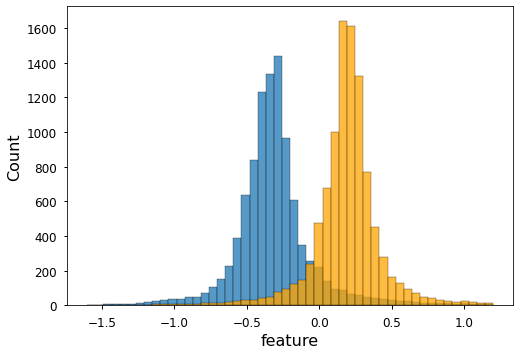

In [15]:
m=10000
sns.histplot(x=rwcs1[1]['feature'][:m], weights=rwcs1[1]['weights'][:m]*m,bins=50,binrange=[-1.6,1.2])
sns.histplot(x=rwcs1[1]['feature'][m:], weights=rwcs1[1]['weights'][m:]*m, bins=50,binrange=[-1.6,1.2],color='orange')

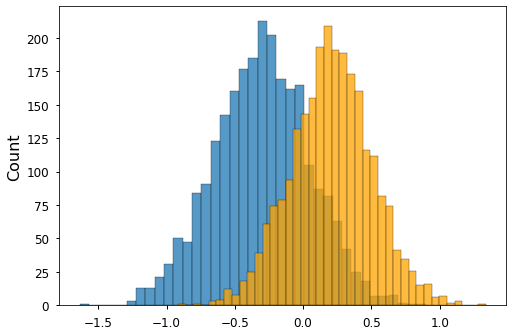

In [16]:
a = sns.histplot(X0)
b = sns.histplot(X1, color='orange')

In [17]:
print(emm.utils.weighted_var(X0, np.ones(m // 4)/ (m // 4)))
print(emm.utils.weighted_var(rwcs1[1]['feature'][:m],rwcs1[1]['weights'][:m]))
print(0.35**2)

AttributeError: 'numpy.ndarray' object has no attribute 'fillna'

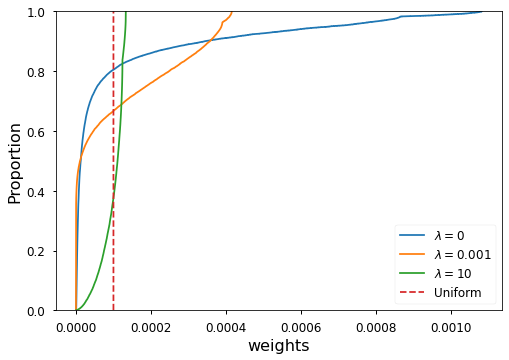

In [18]:
sns.ecdfplot(rwcs1[1]['weights'], label='$\lambda =0$')
sns.ecdfplot(rwcs2[1]['weights'], label="$\lambda =0.001$")
sns.ecdfplot(rwcs3[1]['weights'], label="$\lambda =10$")
plt.plot(np.ones(m)/m, np.linspace(0,1,m), linestyle='--', label='Uniform')
plt.legend()

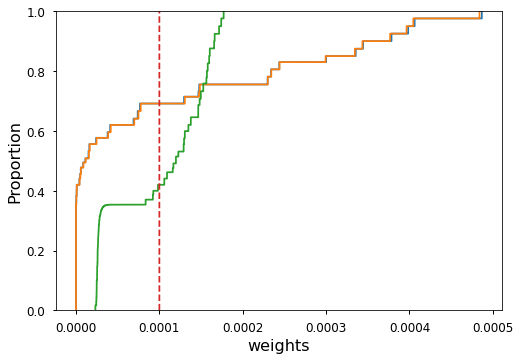

In [19]:
sns.ecdfplot(rwcs1[0]['weights'], label='$\lambda =0$')
sns.ecdfplot(rwcs2[0]['weights'], label="$\lambda =0.001$")
sns.ecdfplot(rwcs3[0]['weights'], label="$\lambda =10$")
plt.plot(np.ones(m)/m,np.linspace(0,1,m), label="Uniform weights", linestyle='--')

In [20]:
sbp = np.random.normal(146,20, 10_000_000)
dbp = np.random.normal(84,11,10_000_000)

In [21]:
np.where(sbp<dbp,1,0).sum() / 10_000_000 * 100

0.33338999999999996

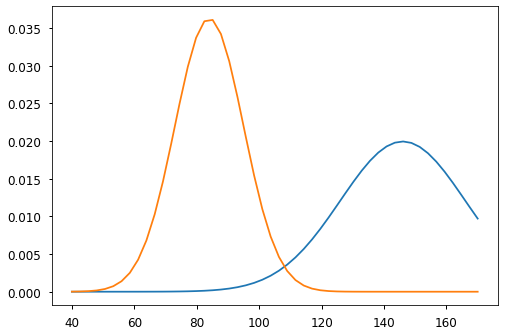

In [22]:
import scipy as sp
sbp = sp.stats.norm(146,20)
dbp = sp.stats.norm(84,11)
x = np.linspace(40,170)
plt.plot(x, sbp.pdf(x))
plt.plot(x, dbp.pdf(x))

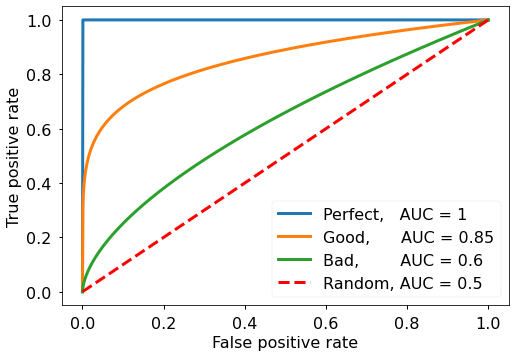

In [23]:
x = np.linspace(0,1,1000)
perf = np.concatenate([np.array([0]),np.ones(999)])
worthless = np.linspace(0,1,1000)
good = x**(1/6) 
bad = x**(3/5)

plt.plot(x, perf, linewidth = 3, label = 'Perfect,   AUC = 1')
plt.plot(x,good, linewidth = 3, label =  'Good,      AUC = 0.85')
plt.plot(x,bad, linewidth = 3, label =   'Bad,        AUC = 0.6')
plt.plot(x,worthless, 'r--', linewidth = 3, label = 'Random, AUC = 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.savefig('ROC_example')
plt.show()

In [24]:
import cvxpy as cp
w = cp.Variable((len(corpus),1))
constrs = [w >= 0, cp.sum(w) == 1]
F = (corpus.values - corpus.values.T @ w)

In [25]:
(corpus.values - (corpus.values.T @ w)[0,0])

Expression(AFFINE, UNKNOWN, (10000, 1))

In [26]:
(corpus.values.T @ w)[0,0]

Expression(AFFINE, UNKNOWN, ())

In [27]:
corpus.values

array([[-1.58329713],
       [-1.08485776],
       [ 0.330125  ],
       ...,
       [ 0.57171981],
       [-0.49063992],
       [-1.27307755]])

In [29]:
x = cp.Variable()
y = cp.Variable()

# DCP problems.
prob1 = cp.Problem(cp.Minimize(cp.square(x - y)),
                    [x + y >= 0])
prob2 = cp.Problem(cp.Maximize(cp.sqrt(x - y)),
                [2*x - 3 == y,
                 cp.square(x) <= 2])

print("prob1 is DCP:", prob1.is_dcp())
print("prob2 is DCP:", prob2.is_dcp())

# Non-DCP problems.

# A non-DCP objective.
obj = cp.Maximize(cp.square(x))
prob3 = cp.Problem(obj)

print("prob3 is DCP:", prob3.is_dcp())
print("Maximize(square(x)) is DCP:", obj.is_dcp())

# A non-DCP constraint.
prob4 = cp.Problem(cp.Minimize(cp.square(x)),
                    [cp.sqrt(x) <= 2])

print("prob4 is DCP:", prob4.is_dcp())
print("sqrt(x) <= 2 is DCP:", (cp.sqrt(x) <= 2).is_dcp())

prob1 is DCP: True
prob2 is DCP: True
prob3 is DCP: False
Maximize(square(x)) is DCP: False
prob4 is DCP: False
sqrt(x) <= 2 is DCP: False


In [50]:
w = cp.Variable((len(corpus),1))
constrs = [w >= 0, cp.sum(w) == 1]
F = (corpus.values- corpus.values.T @ w)**2
cp.multiply(corpus, w) * (1 - 2 * corpus.values.T @ w)

Expression(UNKNOWN, UNKNOWN, (10000, 1))

In [52]:
np.array([1,1,0,0,0]) @ np.array([5/4,5/4,5/6,5/6,5/6]) / sum(np.array([5/4,5/4,5/6,5/6,5/6]))

0.5

In [58]:
5/4*2

2.5